<h1>CNN model za prepoznavanje šalica</h1>
<hr/>
<h2>Iteracija Mike</h2>

<p></p>
<p>dodavanje transfer learninga</p>

In [3]:
import os
import random

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, SpatialDropout2D

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import GlobalAveragePooling2D

In [4]:
# postavljanje sjemena
seed = 77
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
# Postavi direktorije slika
train_dir = "../../Projekt_slike_128/Trening"
test_dir = "../../Projekt_slike_128/Validacija"

In [6]:
#fukcija za generiranje podataka, veličine batchevai broj epoha
def generate_epochs_batchs_data():
    """ određivanje i priprema podataka """
    # Odredi broj epoha i veličinu batcheva
    num_of_epochs = input("Number of epochs:")
    num_of_epochs = int(num_of_epochs)
    size_of_batch = input("Batch size:")
    size_of_batch = int(size_of_batch)
    # Generator podataka sa augmentacijom za trening
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(128, 128), batch_size=size_of_batch, class_mode="categorical"
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=(128, 128), batch_size=size_of_batch, class_mode="categorical"
    )
    return(train_generator,test_generator, num_of_epochs, size_of_batch)

In [7]:
# funkcija za plotanje rezultata
def plots_and_evaluation(history):
    """ funkcija za plotanje točnosti i gubitka  """
    # Plot trening i valuacija - točnost
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    # Plot trening i validacija - gubitak
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

In [8]:
# poziv funkciji za generiranje podataka
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 1
Batch size: 32


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


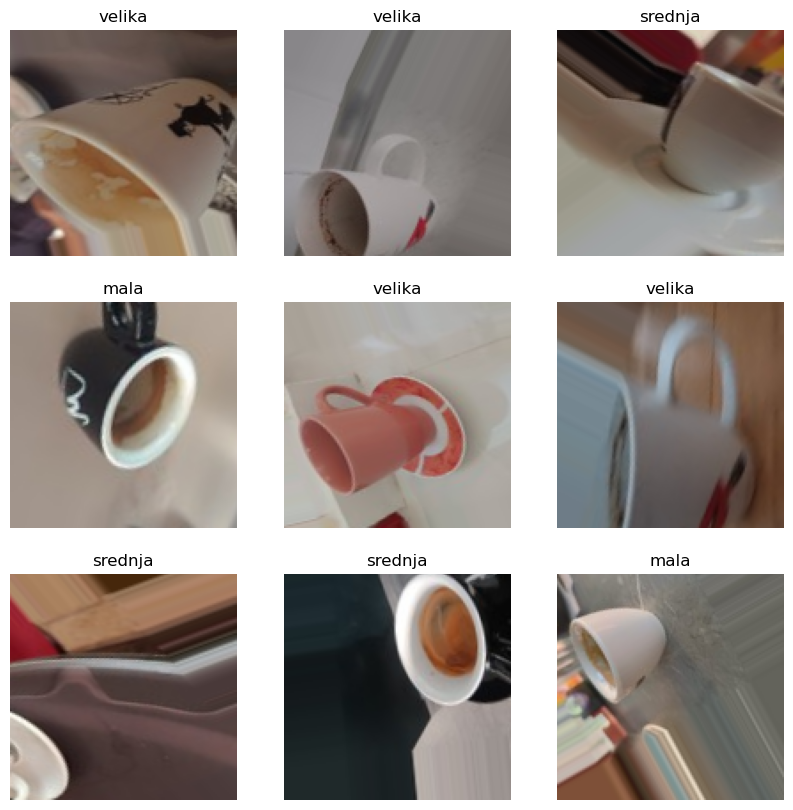

In [9]:
# Primjeri slika
def display_sample_images(generator):
    x, y = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[i])
        
        if (np.argmax(y[i])==0):
            plt.title("mala")
        if (np.argmax(y[i])==1):
            plt.title("srednja")
        if (np.argmax(y[i])==2):
            plt.title("velika")
        plt.axis("off")
    plt.show()


display_sample_images(train_generator)

In [11]:
# Učitavanje pred treniranog modela
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

# DOdavanje slojeva
#
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)

x = Dropout(0.5)(x)  
predictions = Dense(3, activation='softmax')(x)  # Završni izlazni sloj sa 3 klase

# KOmbiniranje  slojeva sa dodanim slojevima(x)
model = Model(inputs=vgg16_model.input, outputs=predictions)


# Odmrzivanje zadnjih 30 pred treniranih slojeva
for layer in vgg16_model.layers[-4:]:
    layer.trainable = True

In [15]:
# poziv funkciji za generiranje podataka
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 150
Batch size: 32


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [12]:
# Kompajliranje modela
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Pregled modela
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [16]:
# Treniranje u 100 epoha
history = model.fit(
    train_generator,
    
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/150
65/65 [==============================] - 166s 3s/step - loss: 1.2178 - accuracy: 0.4207 - val_loss: 1.1165 - val_accuracy: 0.4722
Epoch 2/150
65/65 [==============================] - 165s 3s/step - loss: 1.0704 - accuracy: 0.4937 - val_loss: 1.1068 - val_accuracy: 0.3194
Epoch 3/150
65/65 [==============================] - 166s 3s/step - loss: 0.9896 - accuracy: 0.4966 - val_loss: 0.9231 - val_accuracy: 0.5486
Epoch 4/150
65/65 [==============================] - 166s 3s/step - loss: 0.9606 - accuracy: 0.5232 - val_loss: 1.1523 - val_accuracy: 0.2431
Epoch 5/150
65/65 [==============================] - 165s 3s/step - loss: 0.8628 - accuracy: 0.5338 - val_loss: 1.0785 - val_accuracy: 0.3299
Epoch 6/150
65/65 [==============================] - 165s 3s/step - loss: 0.7904 - accuracy: 0.5827 - val_loss: 0.6731 - val_accuracy: 0.6250
Epoch 7/150
65/65 [==============================] - 164s 3s/step - loss: 0.7568 - accuracy: 0.5991 - val_loss: 0.5810 - val_accuracy: 0.6771
Epoch 

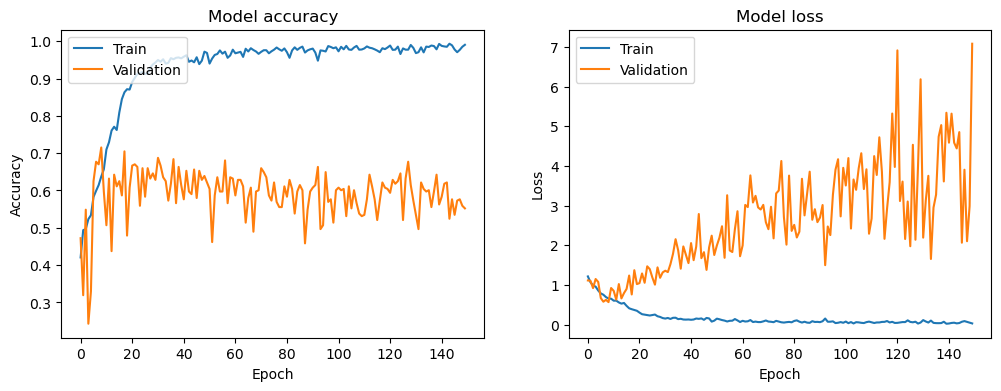

9/9 [==============================] - 7s 737ms/step - loss: 7.1214 - accuracy: 0.5451
Test accuracy: 0.5451388955116272


In [17]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)